# Importing and preprocessing of data

In [1]:
from google.colab import drive

drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
TXTS_PATH = '/content/drive/My Drive/Becode/Kpmg/selection_fr'

In [3]:
import os

In [4]:
import pandas as pd

In [84]:
KPMG_PATH = '/content/drive/My Drive/Becode/Kpmg'
RESPONSES_PATH = '/content/drive/My Drive/Becode/Kpmg/responses_2018_now.json'

In [6]:
txt_filenames = [f for f in os.listdir(TXTS_PATH) if f.endswith(".txt")]

In [7]:
#reading json file to retrieve tags
responses = pd.read_json(RESPONSES_PATH)

In [8]:
#filtering only relevant columns
columns = ['jcId', 'jcFr', 'titleFr', 'themesFr', 'scopeFr', 'noScopeFr', 'documentLink']
responses2 = responses.copy(deep=True).loc[:,columns]
#getting txt_name from original pdf name
responses2["txt_name"] = responses2["documentLink"]
responses2["txt_name"] = responses2["txt_name"].str.replace("/","-")
responses2["txt_name"] = responses2["txt_name"].str.replace(".pdf","_FR.txt")
#filtering json only for selected files and columns
columns += ['txt_name']
responses2 = responses2.loc[responses2.txt_name.isin(txt_filenames), columns]
responses2.head(2)

,jcId,jcFr,titleFr,themesFr,scopeFr,noScopeFr,documentLink,txt_name
34,1110000,COMMISSION PARITAIRE DES CONSTRUCTIONS METALLI...,modification du régime de pension sectoriel so...,[PENSIONS COMPÉMENTAIRES ET ASSURANCES GROUPES],None,[les employeurs et ouvriers des entreprises ex...,111/111-2018-013525.pdf,111-111-2018-013525_FR.txt
35,1110000,COMMISSION PARITAIRE DES CONSTRUCTIONS METALLI...,allocation spéciale compensatoire,[PRIME SYNDICALE],None,None,111/111-2018-012196.pdf,111-111-2018-012196_FR.txt


In [9]:
#generating all possible FR themes
themes_fr = []
for r in  responses2.themesFr:
    if r is not None:
        for t in r:
            if t not in themes_fr:
                themes_fr += [t]
len(themes_fr)


53

In [10]:
#code to retrieve the entire body
#%%
for filename in responses2.txt_name.to_list():
    # filename = responses2.txt_name.to_list()[10] #test
    file_path = os.path.join(TXTS_PATH, filename)
    with open(file_path, 'r', encoding="utf8") as f:
        #to retrieve entire body not necessary
        responses2.loc[responses2.txt_name == filename, "doc_bodies"] = f.read()
        f.close()

In [11]:
t = themes_fr[0]
mask = responses2.dropna(axis=0, subset=['themesFr']).themesFr.map(lambda x: t in x)

In [12]:
len(responses2)

549

In [13]:
 #len(responses2.dropna(axis=0, subset=['themesFr'])[map])

# Preprocessing for NLP

In [ ]:
from pandas import Series

from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer

# import entirely spacy to create Doc objects through nlp
import spacy
from spacy import load, lang

from wordcloud import WordCloud

from collections import Counter

from typing import List
from typing import Dict

# WARNINGS
# W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
# I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine

# GLOBAL VARIABLES
NAMED_ENTITIES = ['microsoft']

#testing
from os import getcwd as cwd
from os.path import dirname as dir
from os.path import join
import pandas as pd

In [60]:
def lemmatize(text_tokens: List[str]) -> List[str]:
    def get_wordnet_pos(word):
        """Map POS tag to first character lemmatize() accepts"""
        tag = pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)

    # Instantiate the WordNetLemmatizer
    wordnet_lemmatizer = WordNetLemmatizer()
    # Lemmatize all tokens into a new list: lemmatized
    texts_lemmatized = [wordnet_lemmatizer.lemmatize(t, get_wordnet_pos(t)) for t in text_tokens]
    return texts_lemmatized


def filter_words(texts_lemmatized: List[List[str]], freq_min=None, freq_max=None):
    frequency_absolute = Counter([item for elem in texts_lemmatized for item in elem])
    wordcloud = WordCloud(width=1000, height=500).generate_from_frequencies(frequency_absolute)
    frequency_relative = wordcloud.words_
    if freq_min is not None and freq_min > 0 and freq_min < 1:
        rel_freq_filtered = {k: v for k, v in frequency_relative.items() if v > freq_min}
    if freq_max is not None and freq_max > 0 and freq_max < 1:
        rel_freq_filtered = {k: v for k, v in frequency_relative.items() if v < freq_max}
    texts_filtered = [[t for t in pub_lem if t in rel_freq_filtered.keys()] for pub_lem in texts_lemmatized]
    # testing part
    f_abs_updated =Counter([ item for elem in texts_filtered for item in elem])   
    wordcloud_updated = WordCloud(width=1000, height=500).generate_from_frequencies(f_abs_updated)
    f_rel_updated = wordcloud_updated.words_
    return texts_filtered, f_abs_updated, f_rel_updated, wordcloud_updated


In [56]:
class Preprocess:
    def __init__(self, nlp_model='en_core_web_md'):
        self.nlp = load(nlp_model)
        if 'en_' in nlp_model:
          self.stop_words = lang.en.stop_words.STOP_WORDS
        elif 'fr_' in nlp_model:
          self.stop_words = lang.fr.stop_words.STOP_WORDS
        self.named_entities = set(NAMED_ENTITIES)

    def get_named_entities(self, texts: Series, inplace=True) -> set:
        # creating a single ner set
        nes = set()
        # function to extract NER from text
        def get_named_entities(text) -> set:
            doc = self.nlp(text)
            named_entities = set([ent.text for ent in doc.ents])
            return named_entities
        [[nes.add(n) for n in get_named_entities(text)] for text in texts]
        # adding predefined NER
        [nes.add(n) for n in self.named_entities]
        if inplace:
            self.named_entities = nes
        return nes

    def tokenize_text(self, text:str, stop_words: List[str] = None, named_entities: List[str] = None,
                   lenght_min: int=2) -> List[str]:
        if stop_words is None:
            stop_words = self.stop_words
        if named_entities is None:
            named_entities = self.named_entities
        text = text.replace("\n", " ")
        # split string into words (tokens)
        tokens = word_tokenize(text.lower())
        # keep strings with only alphabets
        tokens = [t for t in tokens if t.isalpha()]
        tokens = lemmatize(tokens)
        # remove short words, they're probably not useful
        tokens = [t for t in tokens if len(t) > lenght_min]
        # remove stopwords
        tokens = [t for t in tokens if t not in stop_words]
        # remove
        tokens = [t for t in tokens if t not in named_entities]
        return tokens

    def clean_text(self, text:str, stop_words: List[str] = None, named_entities: List[str] = None,
                   lenght_min: int=2) -> str:
        tokens = self.tokenize_text(text, stop_words, named_entities, lenght_min)
        text_cleaned = " ".join(tokens)
        return text_cleaned

    def tokenize_texts(self, texts:Series, stop_words: List[str] = None, named_entities: List[str] = None,
                   lenght_min: int=2) -> List[List[str]]:
        texts_tokens = []
        for text in texts:
            texts_tokens += [self.tokenize_text(text, stop_words, named_entities, lenght_min)]
        return texts_tokens

In [15]:
! python -m spacy download fr_core_news_md

✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_md')


In [16]:
import spacy
nlp = spacy.load('fr_core_news_md')

In [57]:
preprocess = Preprocess(nlp_model='fr_core_news_md')

In [52]:
# example of FR stopwords from the set
list(preprocess.stop_words)[:10]

['pire',
 'suivantes',
 'sa',
 'abord',
 'd’',
 'eh',
 'malgre',
 'pense',
 'pour',
 'elle-même']

In [34]:
# importing nltk and downloading additional required packages
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [35]:
#cleaning text before extracting word clouds
responses2["bodies_cleaned"] = responses2["doc_bodies"].apply(preprocess.clean_text)

# Word cloud labelling

In [58]:
#extracting all words with relative frequency > 0.5
all_ts = preprocess.tokenize_texts(responses2.bodies_cleaned)

In [61]:
texts, f_abs, f_rel, wordcloud = filter_words(all_ts, freq_min=0.5)

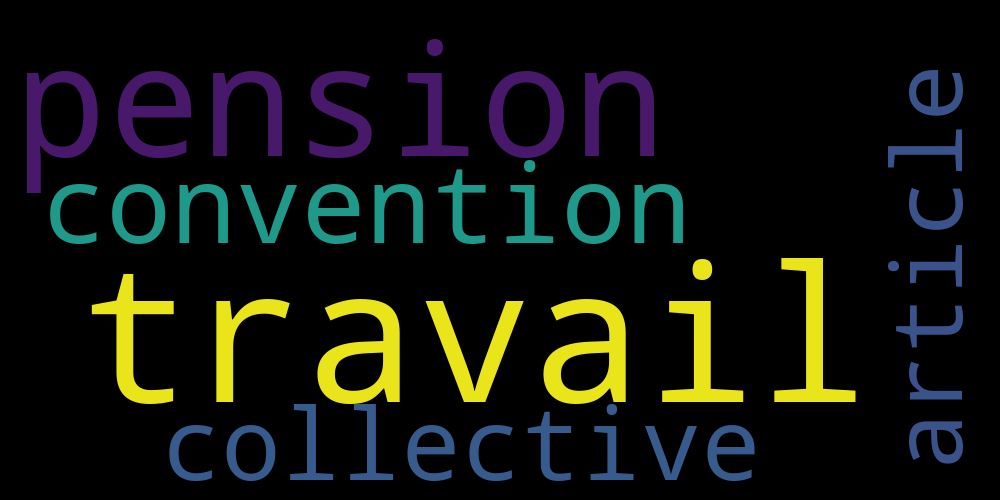

In [62]:
wordcloud.to_image()

In [74]:
# adding most frequent words as stop words
[preprocess.stop_words.add(w) for w in list(f_rel.keys())]
[w for w in list(preprocess.stop_words) if w in list(f_rel.keys())]

['travail', 'convention', 'collective', 'pension', 'article']

In [73]:
[w for w in list(preprocess.stop_words) if w in list(f_rel.keys())]

['travail', 'convention', 'collective', 'pension', 'article']

In [77]:
themes_keywords = pd.DataFrame(columns=['themeFr', 'frequency_absolute', 'frequency_relative'])
for t in themes_fr:
  mask = responses2.dropna(axis=0, subset=['themesFr']).themesFr.map(lambda x: t in x)
  r_t = responses2.dropna(axis=0, subset=['themesFr'])[mask]
  t_ts = preprocess.tokenize_texts(r_t["bodies_cleaned"])
  t_texts, t_f_abs, t_f_rel, t_wordcloud = filter_words(t_ts, freq_min=0.05, freq_max=0.95)
  themes_keywords = themes_keywords.append({'themeFr':t, 'frequency_absolute':t_f_abs, 'frequency_relative':t_f_rel}, ignore_index=True)
  print(f'Kewyords for {t} added')



In [78]:
themes_keywords.to_csv('/content/drive/My Drive/Becode/Kpmg/labeling.csv')

In [83]:
pd.set_option('display.max_colwidth', 255)
themes_keywords.loc[:, ['themeFr','frequency_relative']]

,themeFr,frequency_relative
0,PENSIONS COMPÉMENTAIRES ET ASSURANCES GROUPES,"{'règlement': 1.0, 'régime': 0.9294037011651817, 'solidarité': 0.7655928718300206, 'sectoriel': 0.746401644962303, 'van': 0.7326936257710761, 'complémentaire': 0.5359835503769705, 'ofp': 0.4736120630568883, 'partir': 0.4715558601782042, 'affilié': 0.4..."
1,PRIME SYNDICALE,"{'cotisation': 1.0, 'partir': 0.9273356401384083, 'travailleurs': 0.7923875432525952, 'entreprises': 0.643598615916955, 'janvier': 0.6401384083044983, 'ouvriers': 0.6055363321799307, 'sécurité': 0.5847750865051903, 'formation': 0.5778546712802768, 'co..."
2,TRAVAIL EN ÉQUIPE ET DE NUIT,"{'ouvriers': 1.0, 'prime': 0.9321705426356589, 'minimum': 0.8585271317829457, 'salaires': 0.8430232558139535, 'mois': 0.8003875968992248, 'présente': 0.7306201550387597, 'paritaire': 0.7034883720930233, 'commission': 0.686046511627907, 'juillet': 0.61..."
3,PÉCULE DE VACANCES,"{'mois': 1.0, 'art': 0.9333333333333333, 'juillet': 0.9, 'chômage': 0.7666666666666667, 'vacances': 0.7666666666666667, 'travaux': 0.7333333333333333, 'paritaire': 0.6333333333333333, 'entreprises': 0.6333333333333333, 'commission': 0.6, 'sectoriels':..."
4,PRIME PROPRE AU SECTEUR OU À L'ENTREPRISE,"{'salaires': 1.0, 'minimum': 0.9291338582677166, 'salaire': 0.8110236220472441, 'chapitre': 0.7401574803149606, 'mois': 0.7244094488188977, 'heures': 0.6299212598425197, 'présente': 0.6220472440944882, 'paritaire': 0.6062992125984252, 'ler': 0.6062992..."
5,REMBOURSEMENT DE FRAIS (HORS FRAIS DE DÉPLACEMENT),"{'art': 1.0, 'prime': 0.9014084507042254, 'entreprises': 0.823943661971831, 'ouvriers': 0.6267605633802817, 'paritaire': 0.5985915492957746, 'jours': 0.5985915492957746, 'chauffeur': 0.5774647887323944, 'commission': 0.5563380281690141, 'partir': 0.54..."
6,DÉTACHEMENT,"{'fonds': 1.0, 'van': 0.772189349112426, 'janvier': 0.6627218934911243, 'paritaire': 0.5887573964497042, 'ouvriers': 0.5798816568047337, 'travailleurs': 0.5710059171597633, 'commission': 0.5532544378698225, 'sécurité': 0.5384615384615384, 'durée': 0.5..."
7,PRIME DE FIN D'ANNÉE,"{'fin': 1.0, 'cct': 0.9087719298245615, 'présente': 0.7543859649122807, 'commission': 0.7473684210526316, 'paritaire': 0.7192982456140351, 'travailleurs': 0.6877192982456141, 'chômage': 0.6421052631578947, 'jours': 0.6280701754385964, 'employés': 0.62..."
8,SALAIRES,"{'ouvriers': 1.0, 'salaires': 0.920410783055199, 'paritaire': 0.9114249037227214, 'travailleurs': 0.9101412066752247, 'minimum': 0.9024390243902439, 'commission': 0.8818998716302953, 'partir': 0.8177150192554558, 'présente': 0.7843388960205392, 'mois'..."
9,JEUNES TRAVAILLEURS: SALAIRES,"{'minimum': 1.0, 'salaires': 0.9933920704845814, 'ouvriers': 0.9559471365638766, 'chapitre': 0.6850220264317181, 'mois': 0.6233480176211453, 'juillet': 0.6057268722466961, 'ler': 0.6035242290748899, 'euro': 0.5352422907488987, 'heures': 0.528634361233..."


# Classification model

In [87]:
from pickle import load

with open(os.path.join(KPMG_PATH, "clas_new.pkl"), 'rb') as f:
  df = load(f)

In [88]:
df.columns

Index(['depositNumber', 'displayJcId', 'titleFr', 'themesFr',
       'publicationDate', 'scopeFr', 'endDate', 'enforced', 'docBodyFr'],
      dtype='object')

In [90]:
df["body_cleaned"] = df["docBodyFr"].apply(preprocess.clean_text)

In [91]:
#generating all possible FR themes (replacing previous list of 53 items)
themes_fr = []
for r in  df.themesFr:
    if r is not None:
        for t in r:
            if t not in themes_fr:
                themes_fr += [t]
len(themes_fr)

54

In [105]:
# showing only 27 unique themes against 54 available
df.dropna(axis=0, subset=['themesFr'], inplace=True)
df['theme'] = df['themesFr'].apply(lambda x: x[0] if len(x) == 1 else None)
len(df.theme.unique())

In [113]:
for t in themes_fr:
	df.dropna(axis=0, subset=['themesFr'], inplace=True)
	df[t] = df['themesFr'].apply(lambda x: 1 if t in x else 0)
df.columns

Index(['depositNumber', 'displayJcId', 'titleFr', 'themesFr',
       'publicationDate', 'scopeFr', 'endDate', 'enforced', 'docBodyFr',
       'body_cleaned', 'theme',
       'PENSIONS COMPÉMENTAIRES ET ASSURANCES GROUPES', 'PRIME SYNDICALE',
       'TRAVAIL EN ÉQUIPE ET DE NUIT', 'PÉCULE DE VACANCES',
       'PRIME PROPRE AU SECTEUR OU À L'ENTREPRISE',
       'REMBOURSEMENT DE FRAIS (HORS FRAIS DE DÉPLACEMENT)', 'DÉTACHEMENT',
       'PRIME DE FIN D'ANNÉE', 'SALAIRES', 'JEUNES TRAVAILLEURS: SALAIRES',
       'FORMATION (EXCL. FORMATION SYNDICALE)',
       'TRAVAILLEURS AGÉS-EXCL.PENSIONS COMPL, PRÉPENSION(RCC), CRÉDIT-TEMPS',
       'MALADIE/ACCIDENT/DÉCÈS',
       'CHÔMAGE (AUTRE QUE LE CHÔMAGE ÉCONOMIQUE DES EMPLOYÉS)',
       'RÉGIME DE CHÔMAGE AVEC COMPLÉMENT D'ENTREPRISE (RCC)',
       'FORMATION SYNDICALE', 'FONDS DE SÉCURITÉ D'EXISTENCE',
       'INDEMNITÉS POUR FRAIS DE DÉPLACEMENT',
       'CRÉDIT-TEMPS/DIMINUTION DE CARRIÈRE, EMPLOI FIN DE CARRIÈRE',
       'RECRUTEMENT', 'GR

# Bert classification with Pytorch [[towardsdatascience](https://towardsdatascience.com/bert-text-classification-using-pytorch-723dfb8b6b5b)]

To be checked
[tensorflow tutorial](https://www.tensorflow.org/tutorials/text/classify_text_with_bert)


In [134]:
! pip install transformers

In [135]:
# FM overlaps
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [136]:
#testing for first theme only
t = themes_fr[0]
X_train, X_test, y_train, y_test = train_test_split(df[['body_cleaned',t ]],df[t], test_size = 0.2, random_state=42)

In [139]:
X_train[X_train['PENSIONS COMPÉMENTAIRES ET ASSURANCES GROUPES']==1]

,body_cleaned,PENSIONS COMPÉMENTAIRES ET ASSURANCES GROUPES
documentLink,,
116-116-2018-009678.pdf,service public fédéral emploi relation commission paritaire chimique correction texte néerlandais opvolging van gelijkwaardigheid inséré artikel correction texte frangais décision concertation sociale direction générale direction greffe erratum cct po...,1
200-200-2019-010014.pdf,service public fédéral emploi concertation sociale direction générale relation direction greffe erratum commission paritaire auxiliaire employés cct correction texte français alinéa corrigé conclue compte commun conseil national février suppression pr...,1
209-209-2018-003154.pdf,service public fédéral emploi concertation sociale federale overheidsdienst werkgelegenheid arbeid sociaal overleg direction générale algemene directie relation collectieve arbeidsbetrekkingen direction greffe directie van griffie erratum erratum comm...,1
118-118-2019-010374.pdf,programmation sociale juillet conclue commission paritaire alimentaire avril pris exécution loi juillet promotion emploi sauvegarde préventive compétitivité azb avril fixe marge évolution coût salarial période présente sectorielle accord découleront c...,1
118-118-2020-013487.pdf,commission paritaire alimentaire octobre remplaçant décembre désignant gestionnaire régime complémentaire sectoriel social ouvriers alimentaire instaurant règlement solidarité numéro chapitre ler champ définitions ler présente employeurs ouvriers ress...,1
209-209-2020-008100.pdf,service public fédéral emploi concertation sociale direction générale relation direction greffe erratum commission paritaire employés fabrication métalliques cct correction langues alinéas statuts federale overheidsdienst werkgelegenheid arbeid sociaa...,1
111-111-2019-001595.pdf,federale overheidsdienst werkgelegenheid arbeid sociaal overleg service public fédéral emploi concertation sociale direction générale algemene directie relation collectieve arbeidsbetravail trekkingen direction greffe directie van griffie erratum erra...,1
209-209-2019-015683.pdf,commission paritaire employés fabrication métalliques décembre modification règlement groupe exécute régime sectoriel social note technique sectorielle clarification aspect régime sectoriel champ présente employeurs travailleurs occupés contrat ressor...,1
220-220-2019-015609.pdf,décembre modifiant instaurant régime complémentaire sectoriel social numéro enregistrement chapitre champ définitions art présente employeurs employés relèvent commission paritaire employés industrie alimentaire application numéro exclus champ régime ...,1


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('label', label_field), ('title', text_field), ('text', text_field), ('titletext', text_field)]

# TabularDataset

#train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv',
#                                           test='test.csv', format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)

# Classification model [Philippe's]

In [115]:
# split the dataset in train and validation
from sklearn.model_selection import train_test_split

In [117]:
#testing for first theme only
t = themes_fr[0]
train0, val0 = train_test_split(df[['body_cleaned',t ]],
                              test_size = 0.2)

In [120]:
! pip install transformers

     |████████████████████████████████| 1.9MB 4.1MB/s 
     |████████████████████████████████| 3.2MB 21.0MB/s 
     |████████████████████████████████| 890kB 41.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=4877db601622c52645f045400482f0f7b21a40716899fab0cecbfe5c90214cb3
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [121]:
# load the tokenizer
from transformers import BertTokenizer, BertConfig

config = BertConfig.from_pretrained('bert-base-uncased')
config.output_hidden_states = False
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', config = config)

In [123]:
# tokenize the sentences
# we don't truncate any sentence in the dataset by selecting max_length 40
max_length = 40

encoded_data_train0 = tokenizer(list(train0['body_cleaned']),
                               max_length = max_length,
                               truncation = True,
                               add_special_tokens = True,
                               return_tensors = 'tf',
                               padding = 'max_length',
                               return_attention_mask = True,
                               return_token_type_ids = False,
                               verbose = True)

encoded_data_val0 = tokenizer(list(val0['body_cleaned']),
                               max_length = max_length,
                               truncation = True,
                               add_special_tokens = True,
                               return_tensors = 'tf',
                               padding = 'max_length',
                               return_attention_mask = True,
                               return_token_type_ids = False,
                               verbose = True)

print(encoded_data_train0)
print(encoded_data_val0)

{'input_ids': <tf.Tensor: shape=(424, 40), dtype=int32, numpy=
array([[  101, 20704, 15928, ...,  4183,  2890,   102],
       [  101,  3222, 11968, ..., 11968, 29422,   102],
       [  101,  2326,  2270, ...,  2522, 18752,   102],
       ...,
       [  101,  2326,  2270, ..., 12824,  2102,   102],
       [  101,  3222, 11968, ..., 24501, 21748,   102],
       [  101, 13545,  2015, ...,  4328,  4226,   102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(424, 40), dtype=int32, numpy=
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)>}
{'input_ids': <tf.Tensor: shape=(107, 40), dtype=int32, numpy=
array([[  101,  9413, 11796, ...,  2004,  2063,   102],
       [  101, 14736,  6939, ..., 24782,  2396,   102],
       [  101, 10819,  9496, ...,  3663,  6453,   102],
       ...,
       [  101,  3222, 11968, ...,  2063, 12

In [128]:
# one-hot label creation for type
# @FM: overkilling since already only 1 or 0
from tensorflow.keras.utils import to_categorical


type_vec_train0 = to_categorical(train0[t])
print(type_vec_train0[0])
print(type_vec_train0.shape)

type_vec_val0 = to_categorical(val0[t])
print(type_vec_val0[0])
print(type_vec_val0.shape)

[1. 0.]
(424, 2)
[1. 0.]
(107, 2)


In [129]:
# load a BERT model
from transformers import TFBertModel

model = TFBertModel.from_pretrained('bert-base-uncased', config = config)
display(model.summary())

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
Total params: 109,482,240
Trainable params: 109,482,240
Non-trainable params: 0
_________________________________________________________________


None

In [132]:
! pip install tensorflow_addons

     |████████████████████████████████| 706kB 5.5MB/s 


In [133]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
import tensorflow_addons as tfa

batch_size = 64

#######################################
### ------- Train the model ------- ###
# Set an optimizer
optimizer = Adam(   
    learning_rate=1e-05,   
    epsilon=1e-08,   
    decay=0.01,   
    clipnorm=1.0)
# Set loss and metrics
loss = {t: BinaryCrossentropy(from_logits = True)}
metric = {t: ['accuracy',
                      tfa.metrics.F1Score(num_classes = 1,
                                          threshold = 0.5,
                                          average = 'macro')]}
# metric = {'usecase': ['accuracy'],
#           'type': [CategoricalAccuracy('accuracy')]}
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss,
    metrics = metric)
# Ready output data for the model
y_usecase = train0[t].to_numpy()
# Tokenize the input (takes some time)
x = encoded_data_train
# Fit the model
history = model.fit(   
    x={'input_ids': x['input_ids'], 'attention_mask': x['attention_mask']},   
    y={t: y_usecase},
    batch_size=batch_size,
    epochs=10)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autog

ValueError: ignored